In [52]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
import random
import os
import imageio

In [106]:
def generate_random_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Pre-assign at least one firing event for each neuron across the propagations
    preassigned_firings = {neuron_index: random.randint(0, num_propagations - 1) for neuron_index in range(N_channels)}

    # Generate spike times with specified overlap, breaks, and random firing within rows
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)

        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms

            # Randomly decide which neurons in the row will fire (random proportion)
            firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))

            # Ensure pre-assigned neurons for this propagation are included
            for neuron_index in range(row * cols, (row + 1) * cols):
                if preassigned_firings[neuron_index] == propagation and neuron_index not in firing_neurons_in_row:
                    firing_neurons_in_row.append(neuron_index)

            for neuron_index in firing_neurons_in_row:
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
                train_patterned_overlap[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

    # Create the SpikeData object
    spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_random_firing

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

# def firing_plotter(sd):

#     # Custom colormap from pale red/pink to dark red/black
#     colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
#     cmap_name = "custom_red_black"
#     n_bins = 100  # More bins will give us a finer gradient
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#     firing_rates = calculate_mean_firing_rates(sd)
#     neuron_x, neuron_y = [], []

#     # Extract neuron positions
#     for i, neuron in sd.neuron_data['positions'].items():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])

#     # Adjust size scaling for more variance
#     min_rate, max_rate = np.min(firing_rates), np.max(firing_rates)

#     if min_rate == max_rate:
#         sizes = np.full_like(firing_rates, 50)  # Assign a default size if no variance
#     else:
#         sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale

#     plt.figure(figsize=(8, 6))
#     # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
#     scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
#     plt.title("Neuron Firing Rates")
#     plt.xlabel("X Position")
#     plt.ylabel("Y Position")
#     plt.colorbar(scatter, label='Firing Rate (Hz)')
#     plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):

    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []

    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    # Adjust size scaling for more variance
    min_rate, max_rate = np.min(firing_rates), np.max(firing_rates)

    if min_rate == max_rate:
        sizes = np.full_like(firing_rates, 10)  # Assign a default size if no variance
    else:
        sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale

    plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    scatter = plt.scatter(neuron_x, neuron_y, s=sizes, c=firing_rates,
                          cmap=cm, alpha=0.6, vmin=global_min_rate, vmax=global_max_rate)
    plt.title("Neuron Firing Rates")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    # plt.show()

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

In [108]:
random_overlap_spike_data = generate_random_overlap_spike_data(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=50,
    break_duration_ms=6000  # 6 seconds
)

In [62]:
random_overlap_spike_data.length

60000

In [109]:
random_overlap_spike_data_quarter = random_overlap_spike_data.subtime(0, 15000)

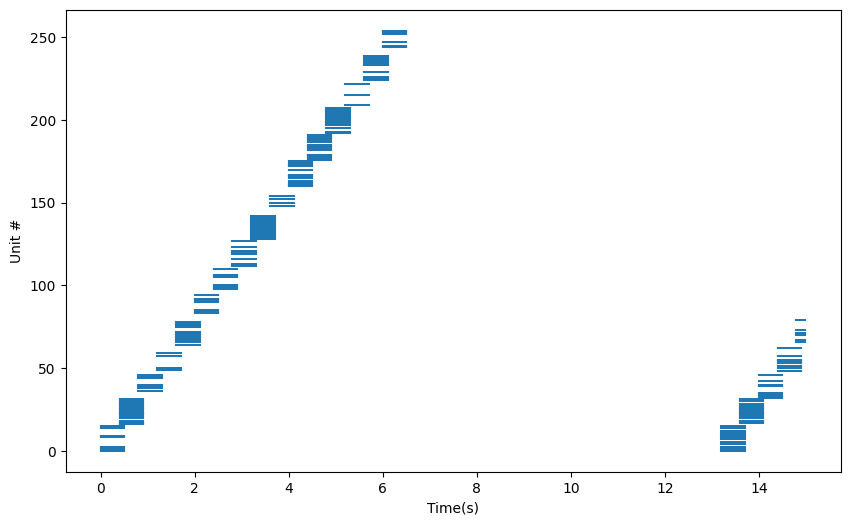

In [110]:
plot_raster(random_overlap_spike_data_quarter)

In [124]:
# # def create_animation(sd, timesteps, output_dir='firing_maps', animation_file='firing_animation.gif'):
# #     # Ensure the output directory is an absolute path
# #     base_path = "/workspaces/human_hippocampus/dev/other/thomas/thesis/"
# #     full_output_dir = os.path.join(base_path, output_dir)
    
# #     if not os.path.exists(full_output_dir):
# #         os.makedirs(full_output_dir)

# #     filenames = []

# #     global_min_rate = np.min(calculate_mean_firing_rates(sd))
# #     global_max_rate = 0

# #     sd_test = sd.subtime(0, 10000)
# #     length = sd_test.length
# #     step = length / timesteps

# #     for timestep in range(timesteps):
# #         sd_timestep = sd_test.subtime(timestep * step, (timestep + 1) * step)
# #         firing_plotter(sd_timestep, global_min_rate, global_max_rate)
        
# #         # Save the plot with an absolute path
# #         filename = os.path.join(full_output_dir, f"step_{timestep}.png")
# #         plt.savefig(filename)
# #         plt.close()
# #         filenames.append(filename)

# #     # Create an animation
# #     # Ensure the animation file path is also absolute
# #     animation_path = os.path.join(base_path, animation_file)
# #     with imageio.get_writer(animation_path, mode='I') as writer:
# #         for filename in filenames:
# #             image = imageio.imread(filename)
# #             writer.append_data(image)
    
# #     # Optionally, print out a message or return the path
# #     print(f"Animation saved to {animation_path}")

# def create_animation(sd, timesteps, output_dir='firing_maps', animation_file='firing_animation.gif'):
#     base_path = "/workspaces/human_hippocampus/dev/other/thomas/thesis/"
#     full_output_dir = os.path.join(base_path, output_dir)
    
#     if not os.path.exists(full_output_dir):
#         os.makedirs(full_output_dir)

#     filenames = []
#     sd_test = sd.subtime(0, 10000)  # Adjust as necessary to capture the correct time segment
#     total_recording_time = sd_test.length  # Total recording time in seconds

#     # Calculate the duration of each frame to match the total recording time
#     duration_per_frame = total_recording_time / timesteps

#     g_min_rate = 0
#     g_max_rate = np.max(calculate_mean_firing_rates(sd))

#     for timestep in range(timesteps):
#         sd_timestep = sd_test.subtime(timestep * (sd_test.length / timesteps), (timestep + 1) * (sd_test.length / timesteps))
        
#         # Call the plotting function without saving
#         firing_plotter(sd_timestep, global_max_rate=g_max_rate, global_min_rate=g_min_rate)  # Your function should plot but not save the figure
        
#         # Save the figure here instead
#         filename = os.path.join(full_output_dir, f"step_{timestep}.png")
#         plt.savefig(filename)
#         plt.close()
#         filenames.append(filename)

#     # Create the GIF
#     animation_path = os.path.join(base_path, animation_file)
#     with imageio.get_writer(animation_path, mode='I', duration=duration_per_frame) as writer:
#         for filename in filenames:
#             image = imageio.imread(filename)
#             writer.append_data(image)
    
#     print(f"Animation saved to {animation_path}")
#     return animation_path

In [125]:
create_animation(random_overlap_spike_data, 100)

/tmp/ipykernel_4678/1033579838.py:111: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():
/tmp/ipykernel_4678/2319858503.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved to /workspaces/human_hippocampus/dev/other/thomas/thesis/firing_animation.gif


'/workspaces/human_hippocampus/dev/other/thomas/thesis/firing_animation.gif'